# RPZ Assignment: AdaBoost

**Detailed BRUTE upload instructions at the end of this notebook.**

## Introduction

The [AdaBoost](https://en.wikipedia.org/wiki/AdaBoost) algorithm takes a class of "weak" (simple) classifiers and boosts their performance by combining them to a strong classifier with adaptive weights assigned to each of the weak classifiers (AdaBoost stands for "adaptive boosting".) This way even relatively simple classifiers can be combined to a classifier with interesting classification accuracy levels.

The Adaboost classifier $H(x)$ has the form:

$$H(x) = \text{sign}(F(x))$$
$$F(x)=\sum^T_{t=1}\alpha_t h_t(x) $$
where $h_t(x)\;: \mathcal{X} \to \{-1, +1\}$ are the weak classifiers selected by the algorithm, and $\alpha_t > 0$ are mixing weights.


### AdaBoost algorithm

**INPUT:** Training data $\{(x_1,y_1),\dotsc,(x_n,y_n)\}$; $x_i \in \mathcal{X}, y_i \in (-1, 1)$, a set of weak classifiers $\mathcal{H}$, number of iterations $T$
* Initialize training data weights: $D_1(i) = 1/n$, for $i = 1,\dots,n$.
*  Initialize $F$ to zero function:  ($\forall x: F(x) = 0$).
* For $t = 1$ to $T$:<br><br>
    1. Select weak classifier with the lowest weighted error:<br><br>
        $h_t = \underset{h \in \mathcal{H}}{\operatorname{argmin}} \ \epsilon(h)$,<br>
        where $\epsilon(h)=\sum^n_{i=1} D_t(i)\mathbf{1}[y_i \neq h(x_i)]$ is the weighted error for weak classifier $h$, and $\mathbf{1}[\cdot]$ is the indicator function ($=1$ if True, and $=0$ if False)<br><br>
    6. Set $\epsilon_t = \epsilon(h_t)$. If $\epsilon_t \geq 0.5$ then stop
    7. Set weak classifier weight: $\alpha_t = \frac{1}{2}\log(\frac{1-\epsilon_t}{\epsilon_t})$
    8. For $i=1,\dots,n$:<br> 
        Update $D_{t+1}(i) = \frac{1}{Z_t}D_t(i)\exp(-\alpha_t y_i h_t(x_i))$,<br> 
        where $Z(t)$ is the normalisation factor which ensures that $D_{t+1}$ is a distribution (i.e. sums up to one)
    10. Update $F$ by the latest selected classifier: $F \leftarrow F + \alpha_t h_t$

**OUTPUT:** Strong classifier $H(x)=\text{sign}(F(x)) = \text{sign}(\sum^T_{t=1}\alpha_t h_t(x))$.




## AdaBoost for image classification

We will use AdaBoost to train a digit classifier. The input to the algorithm will be a set of 13x13 grayscale images of digits and their corresponding labels (0 - 9). We will select one of the digits as the positive class ($y_i = +1$) and the rest of the images as the negative class ($y_i = -1$). The task is then to distinguish the selected digit from the rest of the digits.

We are also free to choose the set of weak classifiers, $\mathcal{H}$. For our case, suitable weak classifiers would include [Local binary patterns](http://en.wikipedia.org/wiki/Local_binary_patterns) (LBPs), various histogram based features, edge-based features, thresholds, decision trees, etc. This is the strength of the AdaBoost algorithm -- we are free to choose a variety of weak classifiers and the algorithm determines which ones are useful for the task.

However, our dataset is rather small and simple, and to see the effects of weak classifiers combination into a stronger one, we will intentionally keep the complexity of the weak classifiers low. Each weak classifier $h_{k}(I; \theta, p)\in\mathcal{H}$ will be based on intensity value $I_k$ of a single pixel $k$ in an image $I$, and will be parametrized by three numbers:
- pixel index $k$,
- intensity threshold $\theta \in \mathbb{R}$, and
- a parity flag $p \in \{+1, -1\}$, indicating whether the positive class intensity is above or below the threshold.

Each such weak classifier takes the image intensity $I_k$ of pixel $k$, compares it with the threshold $\theta$ and determines the class using the parity:
$$h_{k}(I; \theta, p) = \text{sign}(p * (I_k - \theta))$$

Note that we have 13 x 13 = 169 weak classifiers which are further parametrised by the threshold and parity. This gives us a large variety of simple weak classifiers. When searching for the best weak classifier in step 1. of the AdaBoost learning algorithm, we are thus searching over $\theta$ and $p$ parameters of each of the 169 classifiers and select the one with the lowest weighted error.

In [1]:
%load_ext autoreload
%autoreload 2
# uncomment following for interactive matplotlib
# %matplotlib notebook

from adaboost import *
import numpy as np
from numpy import testing
import matplotlib.pyplot as plt

## AdaBoost training

Complete the function `strong_classifier, wc_errors, upper_bound = adaboost(X, y, num_steps)` so that it implements the AdaBoost training. The function accepts training data `X`, their labels `y`, and the number of training steps `num_steps`. It should return:
  - `strong_classifier` - the found strong classifier, in the form of parameters of selected weak classifiers and their combination coefficients $\alpha_t$  (see the code, or the cell with `adaboost` example output below for its structure),
  - `wc_error` - the weighted error of the selected weak classifier selected in each step $t$, and
  - `upper_bound` - the training error upper bound $\prod_{s=1}^t Z_s$ for each step $t$.

To find the best weak classifier, use the function `find_best_weak(X, y, D)` which implements vectorised search for the optimal $\theta$ and $p$.

To reduce the effect of an unbalanced training set (1:9 positive to negative sample size ratio) which would put too much emphasis on the negative samples, initialise the weights $D_1$ such that the $\sum_{i: y_i=-1}D_1(i) = \sum_{i: y_i=+1}D_1(i) = 0.5$.

**Hint 1:** The update of weights $D_{t+1}$ could be easily implemented using vector notation. Try to understand what it does. If anything is unclear, feel free to ask.

**Hint 2:** The update of $D_{t+1}$ can be also written as (substituting in $\alpha_t$) $D_{t+1} = \frac{1}{Z_t} D_t \sqrt{\frac{\varepsilon_t}{1 - \varepsilon_t}}$ if $y_i = h_t(x_i)$ and $D_{t+1} = \frac{1}{Z_t} D_t \sqrt{\frac{1 - \varepsilon_t}{\varepsilon_t}}$ if $y_i \neq h_t(x_i)$.


In [5]:
# a toy problem with 10 "images" X, each consisting of only 2 "pixels":
X = np.array([[1, 1.5, 2.5, 3.0, 3.5, 5, 5.5, 6, 7., 8], [1, 4, 2, 8, 1, 4, 3, 5, 7, 11]])
y = np.array([1, -1, 1, -1, 1, -1, 1, -1, 1, -1])
strong_classifier, wc_error, upper_bound = adaboost(X, y, 3)
# print('strong_classifier: ', strong_classifier, '\nwc_error: ', wc_error, '\nupper_bound: ', upper_bound)
testing.assert_allclose(strong_classifier['alpha'], [1.09861229, 0.80471896, 0.80471896], err_msg='The combination coefs alpha are incorrect')
testing.assert_allclose(wc_error, [0.1, 0.16666667, 0.16666667], err_msg='The wc_error is incorrect')
testing.assert_allclose(upper_bound, [0.6, 0.4472136, 0.33333333], err_msg='The upper_bound is incorrect')
print('NOTE: All values checked for correctness automatically *except* for strong_classifier["wc"]. Pls check that one manually using the commented out ouput above.')
# check the strong_classifier['wc'] manually: 
# -> strong_classifier:  {'wc': array([{'idx': 1, 'theta': 3.5, 'parity': -1},
# ->                                   {'idx': 1, 'theta': 7.5, 'parity': -1},
# ->                                   {'idx': 0, 'theta': 6.5, 'parity': 1}], dtype=object),
# ->                       ...}
print(strong_classifier['wc'])

NOTE: All values checked for correctness automatically *except* for strong_classifier["wc"]. Pls check that one manually using the commented out ouput above.
[{'idx': 1, 'theta': 3.5, 'parity': -1}
 {'idx': 1, 'theta': 7.5, 'parity': -1}
 {'idx': 0, 'theta': 6.5, 'parity': 1}]


Complete the function `errors = compute_error(strong_classifier, X, y)`  which returns the evolution of the error on the set `X` over the training iterations (using longer and longer strong classifier).


In [24]:
trn_errors = compute_error(strong_classifier, X, y)
testing.assert_allclose(trn_errors, [0.1, 0.1, 0.0 ], err_msg = 'The trn_errors are incorrect.')

## Digit recognition
Let's use the AdaBoost to a real digit image classification problem! Experiment with different digits as positive class to test your algorithm.

### Load and prepare data

In [25]:
# load data
data = np.load("data_adaboost.npz", allow_pickle=True)
trn_images = data["trn_images"]
tst_images = data["tst_images"]
trn_labels = data["trn_labels"]
tst_labels = data["tst_labels"]

In [26]:
# preprare training and test data
digit = 6   # positive class (your choice)
n_trn = trn_labels.size
X_trn = np.reshape(trn_images, (-1, n_trn))
y_trn = -np.ones(n_trn) # all labels to -1,
y_trn[trn_labels == digit] = 1 # except the selected digit.

n_tst = tst_labels.size
X_tst = np.reshape(tst_images, (-1, n_tst))
y_tst = -np.ones(n_tst)
y_tst[tst_labels == digit] = 1

### Run training
Let the training run just for 30 iteration first and check the graphs below to see if it behaves correctly. Then you may try to train even stronger classifier by increasing its size (number of iterations).

In [27]:
N_steps = 30
digit_classifier, wc_error, upper_bound = adaboost(X_trn, y_trn, N_steps)

### Training progress visualisation
Compute the train and test errors and plot them along with the training error upper bound and weighted error of the selected weak classifiers over training iterations.

In [28]:
# compute the errors
trn_errors = compute_error(digit_classifier, X_trn, y_trn)
tst_errors = compute_error(digit_classifier, X_tst, y_tst)
min_iter = np.argmin(tst_errors)
min_err = tst_errors[min_iter]
print('minimal test error {}, achieved at iteration #{}'.format(min_err, min_iter))

minimal test error 0.035, achieved at iteration #25


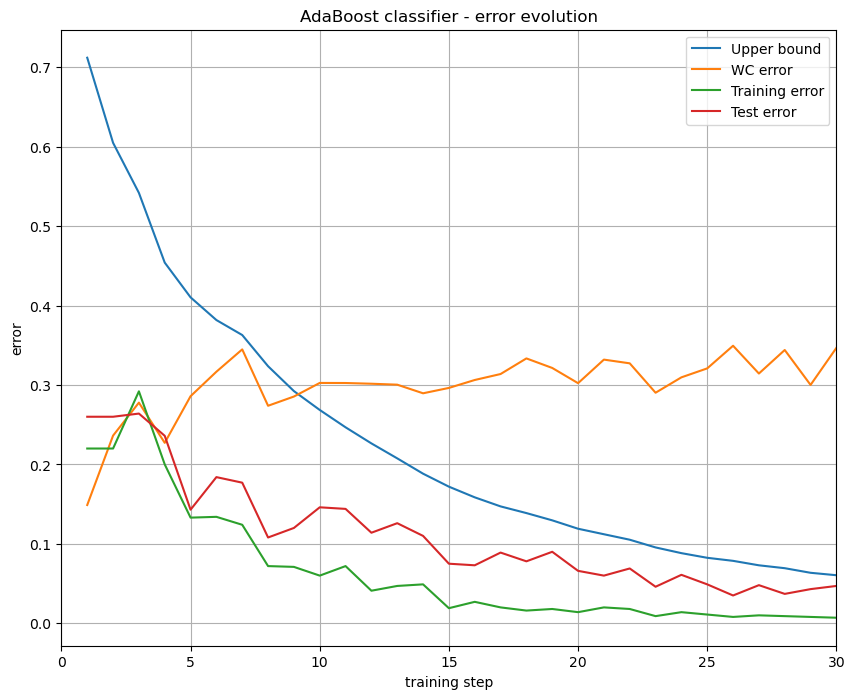

In [29]:
# visualise all collected statistics
steps = range(1, upper_bound.size + 1)
plt.figure(figsize=(10,8))
plt.plot(steps, upper_bound, label='Upper bound')
plt.plot(steps, wc_error, label='WC error')
plt.plot(steps, trn_errors, label='Training error')
plt.plot(steps, tst_errors, label='Test error')
plt.xlabel('training step')
plt.ylabel('error')
plt.grid()
plt.legend()
plt.xlim(0, N_steps)
plt.title('AdaBoost classifier - error evolution')
plt.savefig('error_evolution.png')

The correct implementation should produce output which is identical the the above one.


### Classify images and visualize

Complete the function `classify = adaboost_classify(strong_classifier, X)` which uses the strong classifier to classify new data `X`.

Use the AdaBoost classifier trained on the selected digit (as above) for digit classification, and show the classification results.

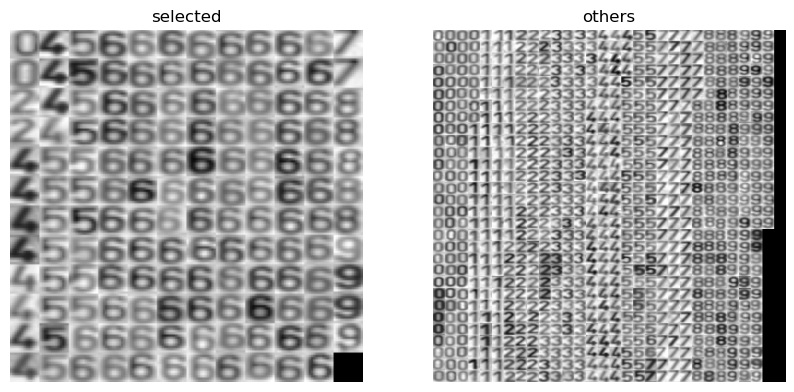

In [30]:
classif = adaboost_classify(digit_classifier, X_tst)
plt.figure(figsize=(10,8))
show_classification(tst_images, classif)
plt.savefig('classification.png')

## Visualize the selected weak classifiers

Use the `show_classifiers` function to visualize the selected weak classifiers. Feel free to use it or even improve it.

<Figure size 500x500 with 0 Axes>

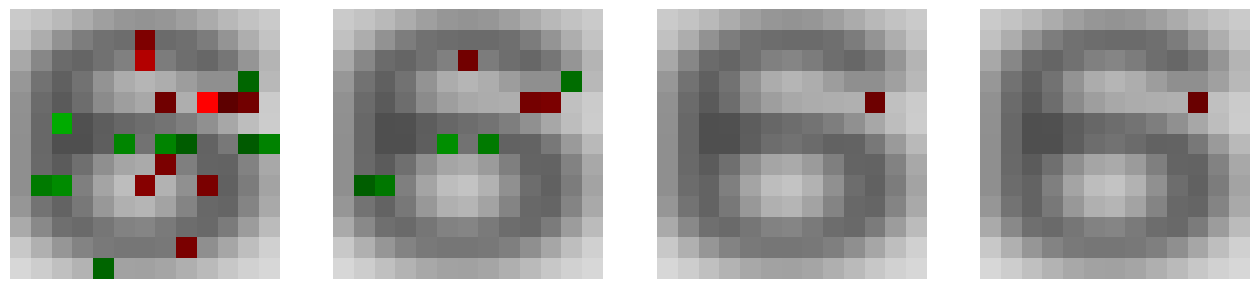

In [31]:
plt.figure(figsize=(5,5))
show_classifiers(trn_images[..., y_trn==1], digit_classifier)
plt.savefig('weak_classifiers.png')

## Submission to the BRUTE Upload System

To fulfill this assignment, you need to submit these files (all packed in one `.zip` file) into the __[upload system](https://cw.felk.cvut.cz/brute/)__:

- `adaboost.ipynb` - a notebook for data initialisation, calling of the implemented functions and plotting of their results (for your convenience, will not be checked).
- `adaboost.py` - file with the following methods implemented:
    - `adaboost` - a function which implements the AdaBoost algorithm
    - `adaboost_classify` - a function which implements the strong classifier classification
    - `compute_error` - a function which implements the strong classifier classification
- `error_evolution.png`, `classification.png`, `weak_classifiers.png` - images specified in the Tasks

When preparing a zip file for the upload system, **do not include any directories**, the files have to be in the zip file root.



## Bonus task

Implement the AdaBoost classifier for the data described in the lecture slides. Each weak classifier is a threshold/parity decision on a radial line from the data centre (the thresholds are actually what is drawn in the slides). Discretise the angles of the directions of the radial lines to a reasonable number (e.g. every 5 degrees).
